In [3]:
## Load packages for all chapter
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
from loader import get_pbp
pbp_py = get_pbp(range(2016, 2022 + 1))

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


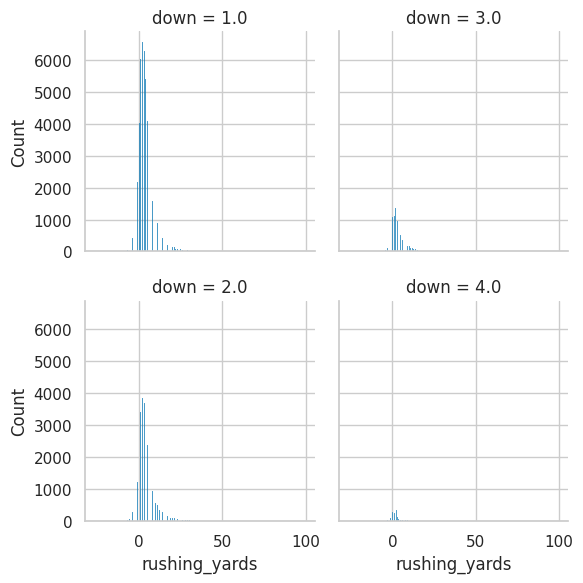

In [ ]:
# Removing non-run plays and non-regular down plays
pbp_py_run = pbp_py.query(
    'play_type == "run" & rusher_id.notnull() &'
    + "down.notnull() & run_location.notnull()"
).reset_index()

pbp_py_run.loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0


## set theme
sns.set_theme(style="whitegrid", palette="colorblind")

# Change down to be an integer
pbp_py_run.down = pbp_py_run.down.astype(str)

# Plot rushing yards by down
g = sns.FacetGrid(data=pbp_py_run, col="down", col_wrap=2)
g.map_dataframe(sns.histplot, x="rushing_yards")
plt.show()



In [7]:
plt.figure(figsize=(6, 4.25), dpi=600)
g = sns.FacetGrid(data=pbp_py_run, col="down", col_wrap=2)
g.map_dataframe(sns.histplot, x="rushing_yards")
plt.savefig("figures/fig_4_1.png", dpi=600)
plt.close()

<Figure size 3600x2550 with 0 Axes>

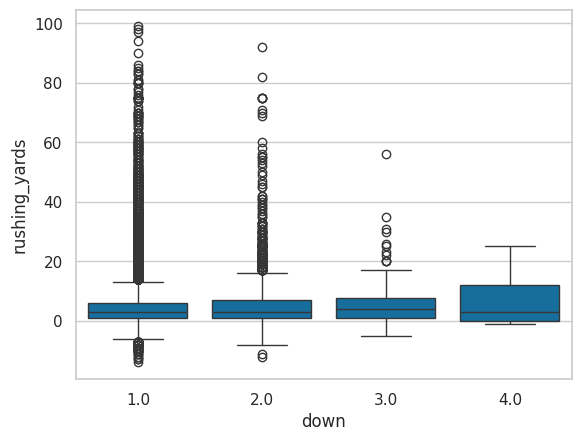

In [8]:
## Look at only plays with 10 yards to go
sns.boxplot(data=pbp_py_run.query("ydstogo == 10"), x="down", y="rushing_yards")
plt.show()

OK, now you see what you expect. This is an example of Simpson’s paradox: including an extra, third grouping variable changes the relationship between the two other variables. Nonetheless, it’s clear that down affects the rushing yards on a play and should be accounted for. Similarly, let’s look at yards to the endzone in seaborn with Figure 4-5 (and change the transparency with scatter_kws={'alpha':0.25} and the regression line color with line_kws={'color': 'red'}):

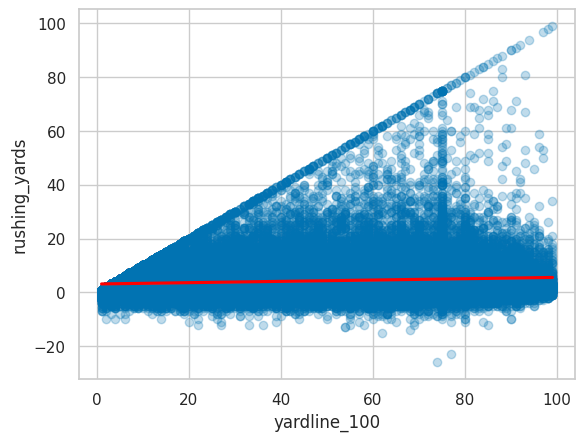

In [9]:
## scatterplot for trendline
sns.regplot(
    data=pbp_py_run,
    x="yardline_100",
    y="rushing_yards",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()


This doesn’t appear to do much, but let’s look at what happens after you bin and average with Python:



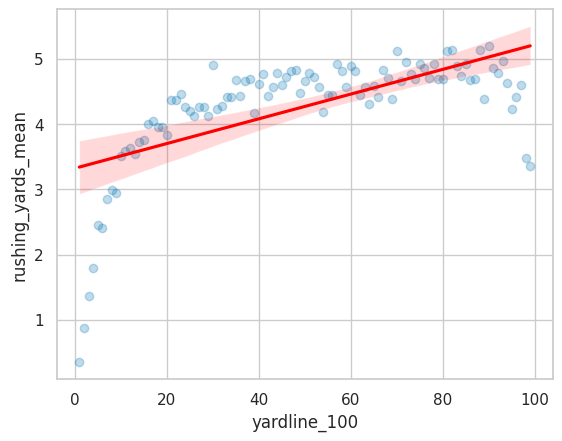

In [ ]:
## Bin and plot
pbp_py_run_y100 = pbp_py_run \
    .groupby("yardline_100") \
    .agg({"rushing_yards": ["mean"]})
pbp_py_run_y100.columns = list(map("_".join, pbp_py_run_y100.columns))
pbp_py_run_y100.reset_index(inplace=True)

sns.regplot(
    data=pbp_py_run_y100,
    x="yardline_100",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()

Running plays with less than about 15 yards to go are limited by distance because there is limited distance to the endzone and tougher red-zone defense. Likewise, plays with more than 90 yards to go take the team out of its own end zone. So, defense will be trying hard to force a safety, and offense will be more likely to either punt or play conservatively to avoid allowing a safety.

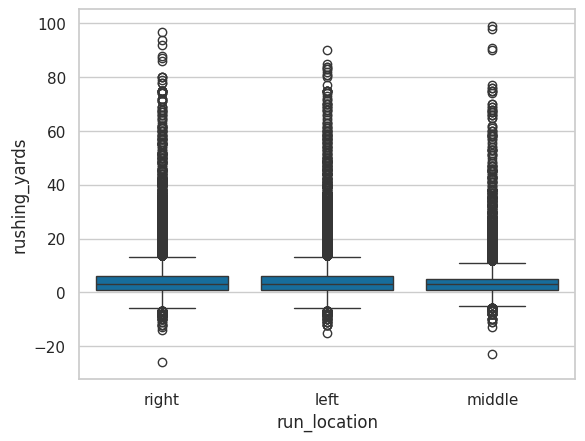

In [11]:
## Boxplot by run location
sns.boxplot(data=pbp_py_run, x="run_location", y="rushing_yards")
plt.show()

Lastly, look at score differential, using the binning and aggregating you used for yards to go to the endzone in Python:

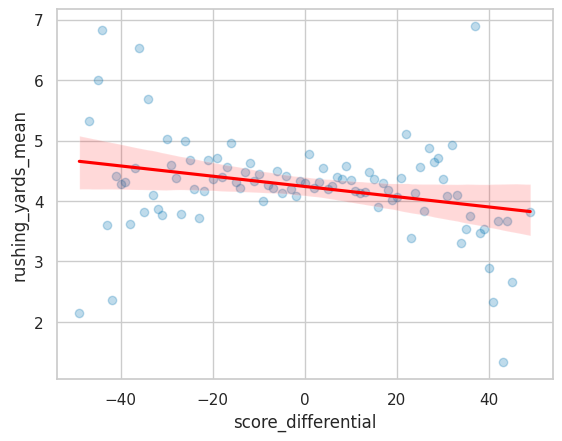

In [12]:
## Score differential
pbp_py_run_sd = pbp_py_run.groupby("score_differential").agg(
    {"rushing_yards": ["mean"]}
)
pbp_py_run_sd.columns = list(map("_".join, pbp_py_run_sd.columns))
pbp_py_run_sd.reset_index(inplace=True)

## plot score differential
sns.regplot(
    data=pbp_py_run_sd,
    x="score_differential",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"},
)
plt.show()

In [13]:
## Multiple regression Python
pbp_py_run.down = pbp_py_run.down.astype(str)
expected_yards_py = smf.ols(
    data=pbp_py_run,
    formula="rushing_yards ~ 1 + down + ydstogo + "
    + "down:ydstogo + yardline_100 + "
    + "run_location + score_differential",
).fit()
pbp_py_run["ryoe"] = expected_yards_py.resid

## Look at model outputs
print(expected_yards_py.summary())


                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     136.6
Date:                Tue, 28 Oct 2025   Prob (F-statistic):          3.22e-313
Time:                        20:31:14   Log-Likelihood:            -2.9760e+05
No. Observations:               91430   AIC:                         5.952e+05
Df Residuals:                   91418   BIC:                         5.953e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [14]:
## Analyze RYOE
ryoe_py = pbp_py_run.groupby(["season", "rusher_id", "rusher"]).agg(
    {"ryoe": ["count", "sum", "mean"], "rushing_yards": ["mean"]}
)
ryoe_py.columns = list(map("_".join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)
ryoe_py = ryoe_py.rename(
    columns={
        "ryoe_count": "n",
        "ryoe_sum": "ryoe_total",
        "ryoe_mean": "ryoe_per",
        "rushing_yards_mean": "yards_per_carry",
    }
).query("n > 50")
print(ryoe_py.sort_values("ryoe_total", ascending=False))

## sort by RYOE per carry
print(ryoe_py.sort_values("ryoe_per", ascending=False))


      season   rusher_id      rusher    n  ryoe_total  ryoe_per  \
1869    2021  00-0036223    J.Taylor  332  471.373827  1.419801   
1349    2020  00-0032764     D.Henry  395  346.025400  0.876014   
1182    2019  00-0034796   L.Jackson  126  328.580099  2.607779   
1069    2019  00-0032764     D.Henry  386  311.725168  0.807578   
1382    2020  00-0033293     A.Jones  221  301.833172  1.365761   
...      ...         ...         ...  ...         ...       ...   
627     2018  00-0027029     L.McCoy  161 -208.339682 -1.294035   
51      2016  00-0027155  R.Jennings  185 -228.810641 -1.236814   
629     2018  00-0027325    L.Blount  154 -235.827214 -1.531346   
991     2019  00-0030496      L.Bell  245 -338.316525 -1.380884   
246     2016  00-0032241    T.Gurley  278 -344.246947 -1.238298   

      yards_per_carry  
1869         5.454819  
1349         5.232912  
1182         6.880952  
1069         5.145078  
1382         5.565611  
...               ...  
627          3.192547  
51 

In [16]:
## RYOE stability
#  keep only the columns needed
cols_keep = ["season", "rusher_id", "rusher", "ryoe_per", "yards_per_carry"]

# create current dataframe
ryoe_now_py = ryoe_py[cols_keep].copy()

# create last-year's dataframe
ryoe_last_py = ryoe_py[cols_keep].copy()

# rename columns
ryoe_last_py.rename(
    columns={"ryoe_per": "ryoe_per_last", "yards_per_carry": "yards_per_carry_last"},
    inplace=True,
)

# add 1 to season
ryoe_last_py["season"] += 1

# merge together
ryoe_lag_py = ryoe_now_py.merge(
    ryoe_last_py, how="inner", on=["rusher_id", "rusher", "season"]
)

## Stability for yards per carry
ryoe_lag_py[["yards_per_carry_last", "yards_per_carry"]].corr()


,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.00000,0.34819
yards_per_carry,0.34819,1.00000


In [17]:

## Stability for RYOE
ryoe_lag_py[["ryoe_per_last", "ryoe_per"]].corr()


,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.373985
ryoe_per,0.373985,1.000000
